# Public Transportation Data

In [1]:
# Lets import our transportation data
import geopandas as gpd
import pandas as pd
import numpy as np

busStops = "../data/Metro_Bus_Stops.geojson"
busStops = gpd.read_file(busStops)
metroStops = "../data/Metro_Stations_(Regional).geojson"
metroStops = gpd.read_file(metroStops)

# busRoutes = "../data/Metro_Bus_Routes.geojson"
# busRoutes = gpd.read_file(busRoutes)

dcBoundary = "../data/Washington_DC_Boundary_Stone_Area.geojson"
dcBoundary = gpd.read_file(dcBoundary)

# Align CRS of bus and metro stops to match DC boundary
busStops = busStops.to_crs(dcBoundary.crs)
metroStops = metroStops.to_crs(dcBoundary.crs)
# busRoutes = busRoutes.to_crs(dcBoundary.crs)

dcPolygon = dcBoundary.geometry.iloc[0]


Transform, clean, and reduce data down to exactly what we need:

- Remove non DC stations and bus stops
- Keep basic meta data about station (name, line color, etc.)

In [2]:
# Remove all stops and stations outside of DC boundary

# Print count of bus stops and metro stations before filtering
print(f"Number of bus stops before filtering: {len(busStops)}")
print(f"Number of metro stations before filtering: {len(metroStops)}")

busStops = busStops[busStops.geometry.within(dcPolygon)]
metroStops = metroStops[metroStops.geometry.within(dcPolygon)]

# Print count of bus stops and metro stations after filtering
print(f"Number of bus stops after filtering: {len(busStops)}")
print(f"Number of metro stations after filtering: {len(metroStops)}")

Number of bus stops before filtering: 8289
Number of metro stations before filtering: 98
Number of bus stops after filtering: 2797
Number of metro stations after filtering: 40


Remove all unnecessary columns, then combine, making sure to deliniate between bus stops and metro stations

In [3]:
print(busStops.columns)
print(metroStops.columns)
# print(busRoutes.columns)

busStops = busStops[
    ["BSTP_MSG_TEXT", "geometry"]
]

metroStops = metroStops[
    ["NAME", "LINE", "geometry"]
]

Index(['REG_ID', 'BSTP_GEO_ID', 'BSTP_OPS_TCD', 'BSTP_EFF_DATE', 'AT_STR',
       'ON_STR', 'BSTP_MSG_TEXT', 'BSTP_LON', 'BSTP_LAT', 'BSTP_OPS_FTU_TCD',
       'SNOWPRIORITY', 'ROUTEID', 'BLOCKKEY', 'SUBBLOCKKEY', 'WARD_ID',
       'SE_ANNO_CAD_DATA', 'GLOBALID', 'OBJECTID', 'geometry'],
      dtype='object')
Index(['NAME', 'ADDRESS', 'LINE', 'TRAININFO_URL', 'WEB_URL', 'GIS_ID',
       'MAR_ID', 'GLOBALID', 'OBJECTID', 'CREATED', 'EDITED',
       'SE_ANNO_CAD_DATA', 'geometry'],
      dtype='object')


Use the bus routes dataframe to match each bus stop with a bus route line, as well as the amount of lines that go through that bus stop

In [4]:
# change BSTP_MSG_TEXT to name for bus stops to make it easier to merge metro stops, and add the string "bus stop" to the text

busStops["BSTP_MSG_TEXT"] = busStops["BSTP_MSG_TEXT"] + " BUS STOP"
busStops = busStops.rename(columns={"BSTP_MSG_TEXT": "NAME"})

# Merge with metro stops. leave line as nan for bus stops, and add the string "metro station" to the text for metro stations, and add a column for type of stop (bus or metro). add column for number of lines for metro stations, and set to nan for bus stops
metroStops["NAME"] = metroStops["NAME"] + " METRO STATION"
public_transportation = pd.concat([busStops, metroStops], ignore_index=True)
public_transportation["LINE"] = public_transportation["LINE"].where(public_transportation["LINE"].isna(), public_transportation["LINE"].astype(str).str.upper())
public_transportation["TYPE"] = np.where(public_transportation["LINE"].isna(), "BUS STOP", "METRO STATION")
public_transportation["NUM_LINES"] = np.where(public_transportation["LINE"].isna(), np.nan, public_transportation["LINE"].str.count(",") + 1)

print(public_transportation[public_transportation["TYPE"] == "METRO STATION"].head(5))
print(public_transportation[public_transportation["TYPE"] == "BUS STOP"].head(5))

                                          NAME                    geometry  \
2797                   Anacostia METRO STATION  POINT (-76.99537 38.86297)   
2798              Eastern Market METRO STATION    POINT (-76.996 38.88463)   
2799                 Potomac Ave METRO STATION   POINT (-76.9855 38.88127)   
2800              Stadium-Armory METRO STATION  POINT (-76.97709 38.88672)   
2801  Rhode Island Ave-Brentwood METRO STATION  POINT (-76.99594 38.92107)   

                      LINE           TYPE  NUM_LINES  
2797                 GREEN  METRO STATION        1.0  
2798  BLUE, ORANGE, SILVER  METRO STATION        3.0  
2799  BLUE, ORANGE, SILVER  METRO STATION        3.0  
2800  BLUE, ORANGE, SILVER  METRO STATION        3.0  
2801                   RED  METRO STATION        1.0  
                                         NAME                    geometry  \
0             Barnaby St SE+HR Dr SE BUS STOP  POINT (-76.99341 38.83033)   
1                 Condon Ter SE+#450 BUS STOP  

## Basic Visualizations

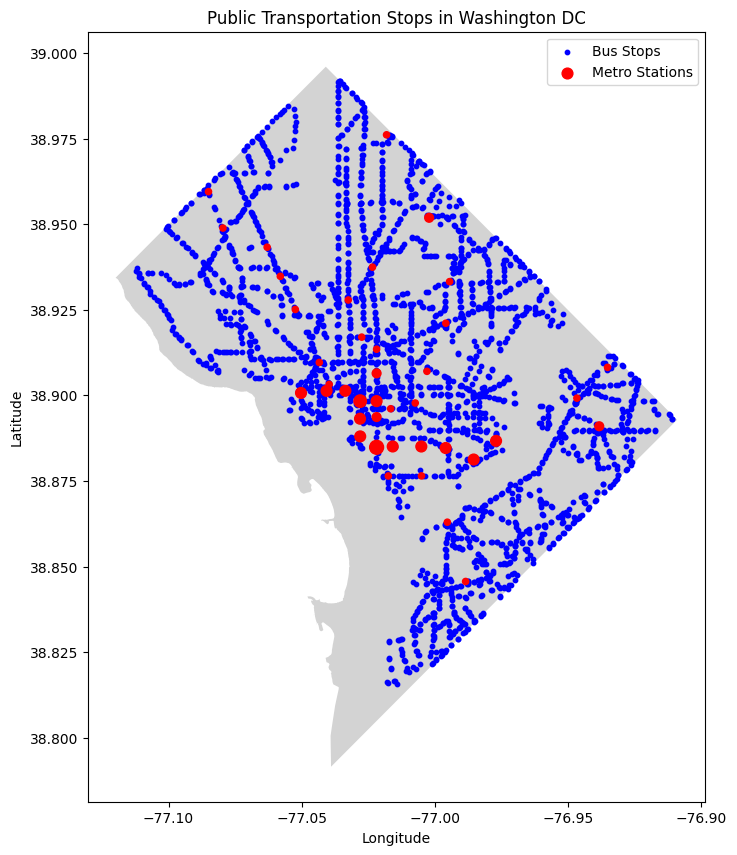

In [5]:
# graph out metro and bus stops on a map of DC using geopandas, with the size of the metro station corresponding to the number of lines that stop at that station

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
dcBoundary.plot(ax=ax, color="lightgrey")
public_transportation[public_transportation["TYPE"] == "BUS STOP"].plot(ax=ax, color="blue", markersize=10, label="Bus Stops")
public_transportation[public_transportation["TYPE"] == "METRO STATION"].plot(ax=ax, color="red", markersize=public_transportation[public_transportation["TYPE"] == "METRO STATION"]["NUM_LINES"] * 20, label="Metro Stations")
plt.legend()
plt.title("Public Transportation Stops in Washington DC")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Exporting our data

In [6]:
# Export cleaned parking zones data
output_file = "../cleaned_data/public_transportation.geojson"

public_transportation.to_file(output_file, driver="GeoJSON")